In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy.integrate import trapz

from wpca.nested_pca import NestedPCA
from wpca.spline import MonotoneQuadraticSplineBasis
from wpca.distribution import PeriodicDistribution
from wpca.barycenter import ProcrustesBarycenter
from wpca.transport import PeriodicTransportMap


from rwass.dimsensionality_reduction.nested_pca import NestedPCA as RNPCA
from rwass.spline import SplineBasis as RSplineBasis
from rwass.spline import MonotoneQuadraticSplineBasis as RMonotoneQuadraticSplineBasis
from rwass.distributions import Distribution as RDistribution

# Simulation 1 - Uniform distributions

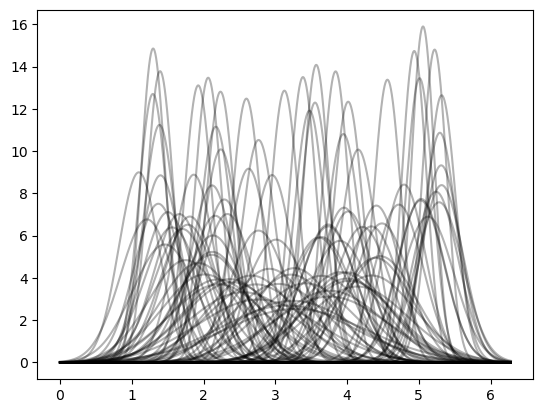

In [103]:
grid = np.linspace(0, 1, 5000)
pdfs = []
np.random.seed(202303)

for i in range(100):
    loc = np.random.uniform(0.15, 0.85)
    scale = 1.0
    while (loc - 3 * scale < 0) or (loc + 3 * scale > 1):
        scale = np.random.uniform(0.025, 0.2)
        
    pdfs.append(stats.norm(loc, scale).pdf(grid))
    plt.plot(grid * 2 * np.pi, pdfs[-1], color="black", alpha=0.3)
    
# plt.savefig("gaussian_data_new.pdf", bbox_inches="tight")

## Standard Wasserstein PCA on R

In [104]:
rmeasures = []

for pdf in pdfs:
    curr = RDistribution()
    curr.init_from_pdf(grid, pdf)
    rmeasures.append(curr)

In [105]:
rnpca = RNPCA(nbasis=50)
rnpca.fit(functions=rmeasures, k=2)

In [106]:
from scipy.interpolate import UnivariateSpline


def invcdf_to_pdf(zero_one_grid, invcdf_eval, s=0.1):
    kept = np.unique(invcdf_eval, return_index=True)[1]
    new_grid = np.linspace(np.min(invcdf_eval), np.max(invcdf_eval), 100)
    cdf = UnivariateSpline(x=invcdf_eval[kept], y=zero_one_grid[kept], s=s)
    der = cdf.derivative()(new_grid)
    return new_grid, der

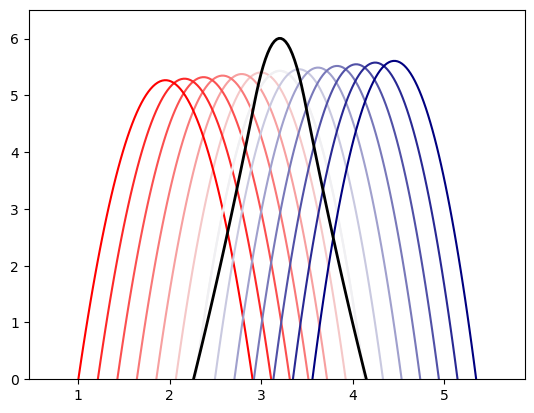

In [115]:
ind = 0

ext_grid = np.linspace(0, 1, 5000)

bary_quant = rnpca.spline_basis.eval_spline(rnpca.bary)
bary_dens = stats.uniform(bary_quant[0], bary_quant[-1] - bary_quant[0]).pdf(ext_grid)

pos_lambdas = np.linspace(0.0001, 0.2, 7)
neg_lambdas = np.linspace(-0.00000000001, -0.2, 7)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))


for i, lam in enumerate(pos_lambdas):
    proj = rnpca.bary + rnpca.project(lam * rnpca.eig_vecs[:, ind])
    quant = rnpca.spline_basis.eval_spline(proj)
    
    grid, dens = invcdf_to_pdf(rnpca.spline_basis.xgrid, quant)
    plt.plot(grid * 2 * np.pi, dens, color=pos_palette[i])
    continue
    
    dens = stats.uniform(quant[0], quant[-1] - quant[0]).pdf(ext_grid)
    plt.plot(ext_grid * 2 * np.pi, dens, color=pos_palette[i])
    
for i, lam in enumerate(neg_lambdas):
    proj = rnpca.bary + rnpca.project(lam * rnpca.eig_vecs[:, ind])
    quant = rnpca.spline_basis.eval_spline(proj)
    
    grid, dens = invcdf_to_pdf(rnpca.spline_basis.xgrid, quant)
    plt.plot(grid * 2 * np.pi, dens, color=neg_palette[i])
    continue
    
    dens = stats.uniform(quant[0], quant[-1] - quant[0]).pdf(ext_grid)
    plt.plot(ext_grid * 2 * np.pi, dens, color=neg_palette[i])

bary_grid, bary_dens = invcdf_to_pdf(ext_grid, 
                          rnpca.spline_basis.eval_spline(rnpca.bary, ext_grid))
plt.plot(bary_grid * 2 * np.pi, bary_dens, color="black", lw=2)
plt.ylim(ymin=0)

plt.savefig("gaussian_pc{0}_rw_new.pdf".format(ind+1), bbox_inches="tight")

## Circular WPCA on S1

In [116]:
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.ndimage.filters import uniform_filter1d
from wpca.spline import MonotoneQuadraticSplineBasis


def get_smooth_cdf(measure, xgrid):
    ext_grid = np.linspace(-1, 2, 5000)
    cdf_eval = measure.periodic_cdf(0, ext_grid)
    cdf_eval = uniform_filter1d(cdf_eval, size=250)
    cdf_spline = UnivariateSpline(ext_grid, cdf_eval, s=0.001)
    return cdf_spline(xgrid)


def get_smooth_pdf(measure, xgrid, s=0.01):
    ext_grid = np.linspace(-1, 2, 5000)
    cdf_eval = measure.periodic_cdf(0, ext_grid)
    cdf_eval = uniform_filter1d(cdf_eval, size=250)
    cdf_spline = UnivariateSpline(ext_grid, cdf_eval, s=s)
    return cdf_spline.derivative()(xgrid)

/var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/ipykernel_95094/658102457.py:2: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [118]:
s1measures = []
grid = np.linspace(0, 1, 5000)

for pdf in pdfs:
    cdf = np.cumsum(pdf) * (grid[1]- grid[0])
    dist = PeriodicDistribution(supp_grid=grid, cdf_eval=cdf)
    s1measures.append(dist)

In [119]:
bary = ProcrustesBarycenter(maxiter=100, threshold=1e-4)
bary.compute(s1measures)
bary_measure = bary.bary_measure

0.0054892177853388575
0.002206221753380508
0.0010015133057490677
0.0005335515611263846
0.00036346156631831915
0.0002602136633043518
0.00020355701553194622
9.68813023194724e-05


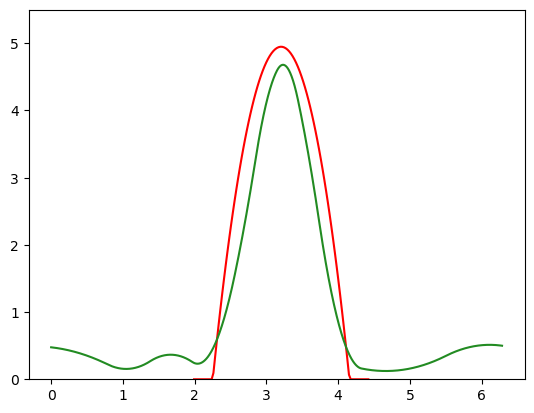

In [125]:
barygrid, barydens = invcdf_to_pdf(rnpca.spline_basis.xgrid, rnpca.bary)
barydens[barydens < 0] = 0
barydens /= trapz(barydens, barygrid)
plt.plot(barygrid * 2 * np.pi, barydens, color="red")

bary_pdf = get_smooth_pdf(bary_measure, grid, 0.005)
plt.plot(grid * 2 * np.pi, bary_pdf, color="forestgreen")
plt.ylim(0, 5.5)
    
plt.savefig("gaussian_bary_s1vsr_new.pdf", bbox_inches="tight")

In [126]:
npca = NestedPCA(nbasis=50)
npca.fit(s1measures, bary_measure, 10)

In [471]:
err_by_dim = []
scores = npca.transform(s1measures)

for dim in range(1, 11):
    curr_scores = scores.copy()
    curr_scores[:, dim:] = 0

    rec_coeffs = npca.pt_from_proj(curr_scores) + npca.center
    
    errs = []
    dists_from_bary = []
    for i in range(len(s1measures)):
        print("\r{0} / {1}".format(i+1, len(s1measures)), flush=True, end=" ")
        tmap = PeriodicTransportMap(bary_measure)
        t_eval = npca.spline_basis.eval_spline(rec_coeffs[i, :])
        rec_measure = tmap.get_pushforward_from_transport(
            npca.spline_basis.xgrid, t_eval)
        tmap2 = PeriodicTransportMap(s1measures[i])
        tmap2.compute(rec_measure)
        errs.append(tmap2.wdist(tmap2.theta, quant_grid))
        
    err_by_dim.append(np.mean(np.array(errs)))

100 / 100   

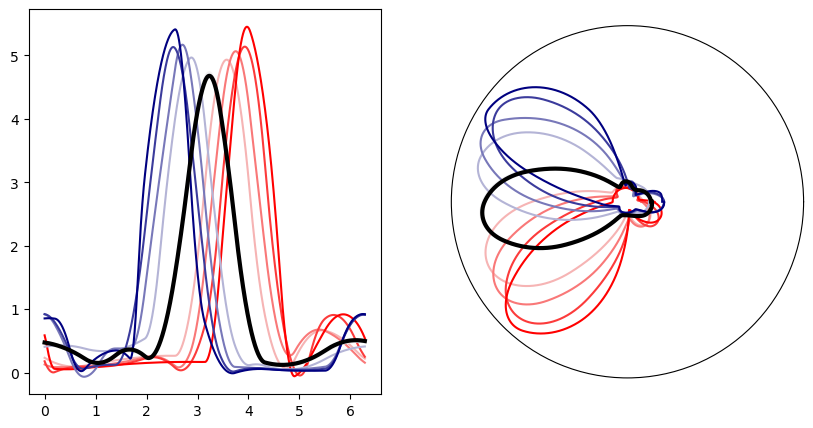

In [129]:
import seaborn as sns

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

ind = 0

ext_grid = np.linspace(0, 1, 10000)
theta_grid = 2 * np.pi * ext_grid

pos_lambdas = np.linspace(0.0001, 0.2, 5)
neg_lambdas = np.linspace(-0.001, -0.2, 5)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))

for i, lam in enumerate(pos_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    
    pdf = get_smooth_pdf(m, ext_grid)
    ax1.plot(ext_grid * 2 * np.pi, pdf, color=pos_palette[i], alpha=1.0)
    ax2.plot(ext_grid * 2 * np.pi, pdf, color=pos_palette[i], alpha=1.0)

    
for i, lam in enumerate(neg_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    
    pdf = get_smooth_pdf(m, ext_grid)
    ax1.plot(ext_grid * 2 * np.pi, pdf, color=neg_palette[i], alpha=1.0)
    ax2.plot(ext_grid * 2 * np.pi, pdf, color=neg_palette[i], alpha=1.0)
    

ax1.plot(grid * 2 * np.pi, bary_pdf, color="black", lw=3)
ax2.plot(grid * 2 * np.pi, bary_pdf, color="black", lw=3)
ax2.set_xticks([])
ax2.set_yticks([])
    
plt.savefig("gaussian_pc1_s1w_new.pdf", bbox_inches="tight")
plt.show()

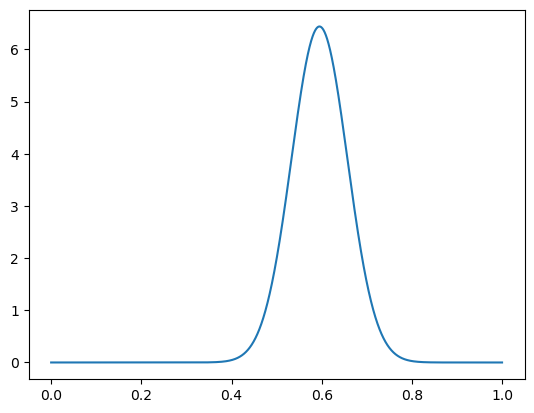

In [127]:
ind = -1

plt.plot(grid, pdfs[-1])

In [130]:
central_point = s1measures[-1]

npca2 = NestedPCA(nbasis=50)
npca2.fit(s1measures, central_point, 10)

In [461]:
err_by_dim2 = []
scores = npca2.transform(s1measures)

for dim in range(1, 11):
    curr_scores = scores.copy()
    curr_scores[:, dim:] = 0

    rec_coeffs = npca2.pt_from_proj(curr_scores) + npca2.center
    
    errs = []
    dists_from_bary = []
    for i in range(len(s1measures)):
        print("\r{0} / {1}".format(i+1, len(s1measures)), flush=True, end=" ")
        tmap = PeriodicTransportMap(central_point)

        t_eval = npca2.spline_basis.eval_spline(rec_coeffs[i, :])
        rec_measure = tmap.get_pushforward_from_transport(
            npca2.spline_basis.xgrid, t_eval)
        tmap2 = PeriodicTransportMap(s1measures[i])
        tmap2.compute(rec_measure)
        errs.append(tmap2.wdist(tmap2.theta, quant_grid))
        
    err_by_dim2.append(np.mean(np.array(errs)))

100 / 100 

In [131]:
def get_push_cdf(init_point, grid, trans_eval):

    trans_inv = interp1d(trans_eval, grid, kind="linear")  
    new_grid = np.linspace(np.min(trans_eval), np.max(trans_eval), 10000)
    cdf_eval = init_point.periodic_cdf(0, trans_inv(new_grid))
    return new_grid, cdf_eval

    zero_idx = np.sum(new_grid < 0)
    cdf_eval = cdf_eval - cdf_eval[zero_idx]

    wh = np.where((new_grid >= 0) & (new_grid <= 1))
    new_grid = new_grid[wh]
    cdf_eval = cdf_eval[wh]
    cdf_eval = cdf_eval - cdf_eval[0]
    out = PeriodicDistribution(supp_grid=new_grid, cdf_eval=cdf_eval)

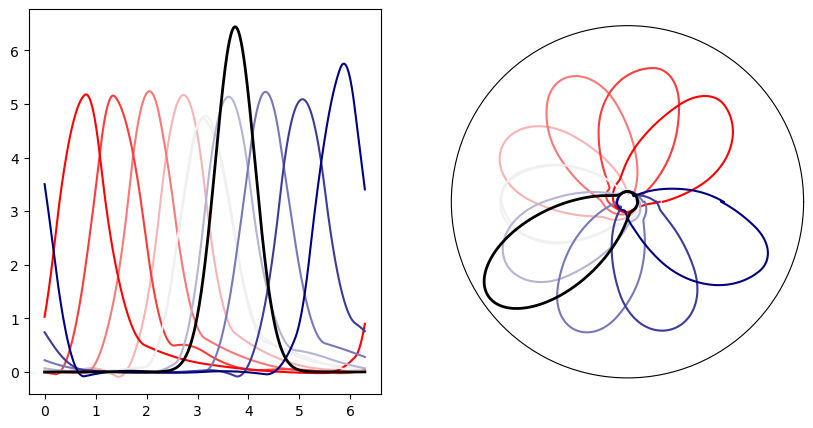

In [132]:
import seaborn as sns

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

ind = 0

ext_grid = np.linspace(0, 1, 10000)
theta_grid = 2 * np.pi * ext_grid

pos_lambdas = np.linspace(0.0001, 3, 5)
neg_lambdas = np.linspace(-0.001, -1.2, 5)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))

for i, lam in enumerate(pos_lambdas):
    proj = npca2.center + npca2.project(lam * npca2.eig_vecs[:, ind])
    transport = PeriodicTransportMap(central_point)
    t_eval = npca2.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca2.spline_basis.xgrid, t_eval)
    
    grid, cdf = get_push_cdf(central_point, npca2.spline_basis.xgrid, t_eval)

    pdf = get_smooth_pdf(m, ext_grid)
    ax1.plot(ext_grid * 2 * np.pi, pdf, color=pos_palette[i], alpha=1.0)
    ax2.plot(ext_grid * 2 * np.pi, pdf, color=pos_palette[i], alpha=1.0)
    
    
for i, lam in enumerate(neg_lambdas):
    proj = npca2.center + npca2.project(lam * npca2.eig_vecs[:, ind])
    transport = PeriodicTransportMap(central_point)
    t_eval = npca2.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    
    pdf = get_smooth_pdf(m, ext_grid)
    ax1.plot(ext_grid * 2 * np.pi, pdf, color=neg_palette[i], alpha=1.0)
    ax2.plot(ext_grid * 2 * np.pi, pdf, color=neg_palette[i], alpha=1.0)
    
grid = np.linspace(0, 1, 5000)
ax1.plot(grid * 2 * np.pi, pdfs[-1], color="black", alpha=1.0, lw=2)
ax2.plot(grid * 2 * np.pi, pdfs[-1], color="black", alpha=1.0, lw=2)


ax2.set_xticks([])
ax2.set_yticks([])
    
plt.savefig("gaussian_pc1_s1w_newcenter_new.pdf", bbox_inches="tight")
plt.show()

# Simulation 2 - Von Mises Distributions

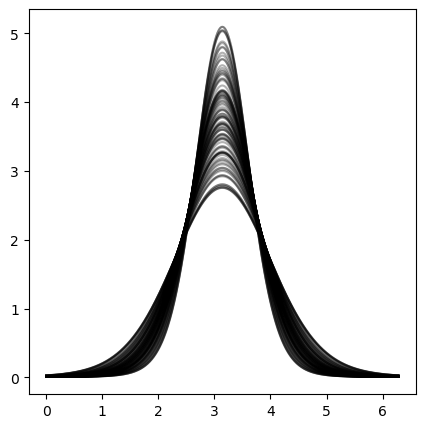

In [100]:
from scipy.stats import vonmises

fig = plt.figure(figsize=(5, 5))

grid = np.linspace(0, 1, 5000)
pdfs = []
np.random.seed(202303)

for i in range(100):
    loc = 0
    scale = np.random.uniform(0.8, 1.5)
        
    pdfs.append(vonmises(3, loc, scale).pdf(2 * np.pi * grid - np.pi) * 2 * np.pi)
    plt.plot(grid * 2 * np.pi, pdfs[-1], color="black", alpha=0.3)
plt.savefig("vonmises_smallscale_data_new.pdf".format(ind+1), bbox_inches="tight")

In [92]:
s1measures = []

for pdf in pdfs:
    cdf = np.cumsum(pdf) * (grid[1]- grid[0])
    dist = PeriodicDistribution(supp_grid=grid, cdf_eval=cdf)
    s1measures.append(dist)

0.0029174591905621367
1.734537110816908e-05
1.7713810321302223e-05
1.996246192878593e-05
1.996134734184308e-05
1.9960528056483602e-05
1.9960264001379397e-05
1.9960136056026538e-05
1.9960074925336923e-05
1.9960045995107752e-05
1.996003246418161e-05
1.9960026144003688e-05
1.9960023178214246e-05
1.996002177486827e-05
1.9960021137964255e-05


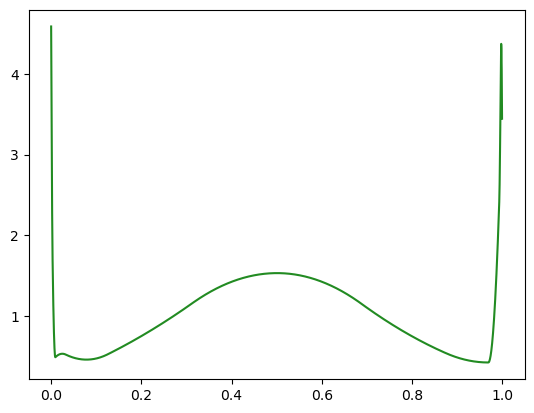

In [94]:
bary = ProcrustesBarycenter(maxiter=15, threshold=1e-6)
bary.compute(s1measures)
bary_measure = bary.bary_measure

grid = np.linspace(0, 1, 5000)
plt.plot(grid, bary_measure.eval_smooth_pdf(grid), color="forestgreen")

In [95]:
npca = NestedPCA(nbasis=50)
npca.fit(s1measures, bary_measure, 2)

In [96]:
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.ndimage.filters import uniform_filter1d
from wpca.spline import MonotoneQuadraticSplineBasis


def get_smooth_cdf(measure, xgrid, s=0.001):
    ext_grid = np.linspace(-1, 2, 5000)
    cdf_eval = measure.periodic_cdf(0, ext_grid)
    cdf_eval = uniform_filter1d(cdf_eval, size=250)
    cdf_spline = UnivariateSpline(ext_grid, cdf_eval, s=s)
    return cdf_spline(xgrid)


def get_smooth_pdf(measure, xgrid, s=0.001):
    ext_grid = np.linspace(-1, 2, 5000)
    cdf_eval = measure.periodic_cdf(0, ext_grid)
    cdf_eval = uniform_filter1d(cdf_eval, size=250)
    cdf_spline = UnivariateSpline(ext_grid, cdf_eval, s=s)
    return cdf_spline.derivative()(xgrid)

/var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/ipykernel_95094/1916804646.py:2: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


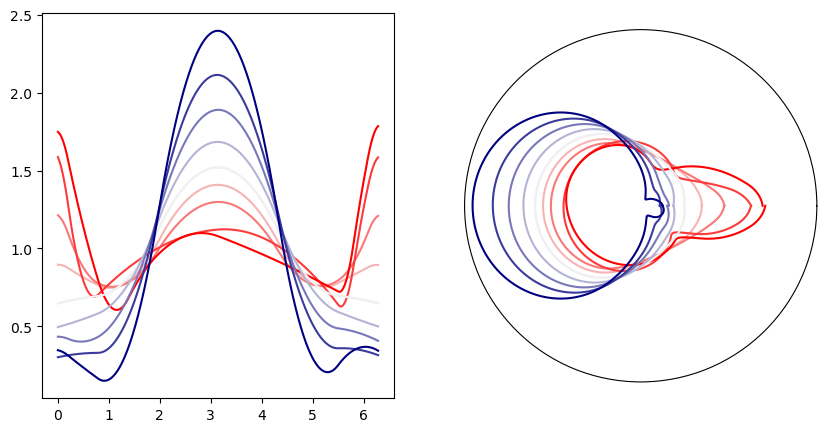

In [98]:
import seaborn as sns

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

ind = 0

ext_grid = np.linspace(0, 1, 10000)
theta_grid = 2 * np.pi * ext_grid

pos_lambdas = np.linspace(0.000001, 0.1, 5)
neg_lambdas = np.linspace(-0.000001, -0.1, 5)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))

for i, lam in enumerate(pos_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    pdf = get_smooth_pdf(m, ext_grid, s=0.05)
    
    ax1.plot(theta_grid,  pdf, color=pos_palette[i], alpha=1.0)
    ax2.plot(theta_grid, pdf, color=pos_palette[i], alpha=1.0)
    
    
for i, lam in enumerate(neg_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    pdf = get_smooth_pdf(m, ext_grid, s=0.05)
    
    ax1.plot(theta_grid,  pdf, color=neg_palette[i], alpha=1.0)
    ax2.plot(theta_grid, pdf, color=neg_palette[i], alpha=1.0)
    

#ax1.plot(ext_grid, bary_measure.periodic_cdf(0, ext_grid), color="red", lw=3)
#ax2.plot(theta_grid, bary_measure.eval_smooth_pdf(ext_grid), color="red", lw=3)
#ax1.set_xlim(0, 1)
#ax1.set_ylim(0, 1)

ax2.set_xticks([])
ax2.set_yticks([])
    
# plt.savefig("vonmises_largescale_pc{0}_new.pdf".format(ind+1), bbox_inches="tight")
plt.show()

## Standard Wasserstein PCA on R

In [225]:
rmeasures = []

for pdf in pdfs:
    curr = RDistribution()
    curr.init_from_pdf(grid, pdf)
    rmeasures.append(curr)

In [226]:
rnpca = RNPCA(nbasis=50)
rnpca.fit(functions=rmeasures, k=10)

In [238]:
from scipy.interpolate import UnivariateSpline


def invcdf_to_pdf(zero_one_grid, invcdf_eval, s=0.05):
    kept = np.unique(invcdf_eval, return_index=True)[1]
    new_grid = np.linspace(np.min(invcdf_eval), np.max(invcdf_eval), 100)
    cdf = UnivariateSpline(x=invcdf_eval[kept], y=zero_one_grid[kept], s=s)
    der = cdf.derivative()(new_grid)
    return new_grid, der

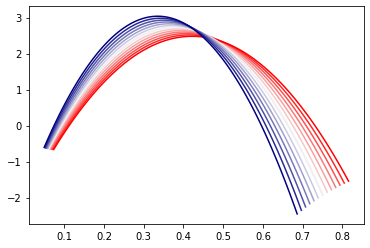

In [240]:
ind = 0

ext_grid = np.linspace(0, 1, 5000)

bary_quant = rnpca.spline_basis.eval_spline(rnpca.bary)
bary_dens = stats.uniform(bary_quant[0], bary_quant[-1] - bary_quant[0]).pdf(ext_grid)

pos_lambdas = np.linspace(0.0001, 0.05, 7)
neg_lambdas = np.linspace(-0.001, -0.05, 7)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))


for i, lam in enumerate(pos_lambdas):
    proj = rnpca.bary + rnpca.project(lam * rnpca.eig_vecs[:, ind])
    quant = rnpca.spline_basis.eval_spline(proj)
    grid, dens = invcdf_to_pdf(rnpca.spline_basis.xgrid, quant)
    plt.plot(grid, dens, color=pos_palette[i])
    
for i, lam in enumerate(neg_lambdas):
    proj = rnpca.bary + rnpca.project(lam * rnpca.eig_vecs[:, ind])
    quant = rnpca.spline_basis.eval_spline(proj)
    grid, dens = invcdf_to_pdf(rnpca.spline_basis.xgrid, quant)
    plt.plot(grid, dens, color=neg_palette[i])
    
#plt.plot(ext_grid, bary_dens, color="black", lw=2)
# plt.savefig("vonmises_pc1_rw.pdf", bbox_inches="tight")

## Circular WPCA on S1

In [229]:
s1measures = []


for pdf in pdfs:
    cdf = np.cumsum(pdf) * (grid[1]- grid[0])
    dist = PeriodicDistribution(supp_grid=grid, cdf_eval=cdf)
    s1measures.append(dist)

In [230]:
bary = ProcrustesBarycenter(maxiter=100, threshold=1e-4)
bary.compute(s1measures)
bary_measure = bary.bary_measure

0.0032177942082046024
0.0007639800194433874
0.00023969138765565082
8.612437416626688e-05


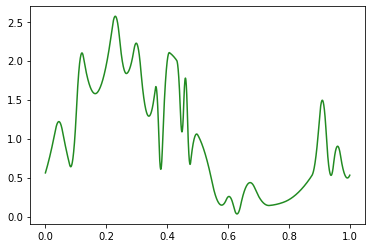

In [246]:
# plt.plot(grid, bary_dens, color="red")
grid = np.linspace(0, 1, 5000)
plt.plot(grid, bary_measure.eval_smooth_pdf(grid), color="forestgreen")
# plt.savefig("vonmises_bary_s1vsr.pdf", bbox_inches="tight")

In [247]:
npca = NestedPCA(nbasis=50)
npca.fit(s1measures, bary_measure, 10)

In [61]:
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.ndimage.filters import uniform_filter1d
from wpca.spline import MonotoneQuadraticSplineBasis


def get_smooth_cdf(measure, xgrid):
    ext_grid = np.linspace(-1, 2, 5000)
    cdf_eval = measure.periodic_cdf(0, ext_grid)
    cdf_eval = uniform_filter1d(cdf_eval, size=250)
    cdf_spline = UnivariateSpline(ext_grid, cdf_eval, s=0.001)
    return cdf_spline(xgrid)


def get_smooth_pdf(measure, xgrid):
    ext_grid = np.linspace(-1, 2, 5000)
    cdf_eval = measure.periodic_cdf(0, ext_grid)
    cdf_eval = uniform_filter1d(cdf_eval, size=250)
    cdf_spline = UnivariateSpline(ext_grid, cdf_eval, s=0.01)
    return cdf_spline.derivative()(xgrid)

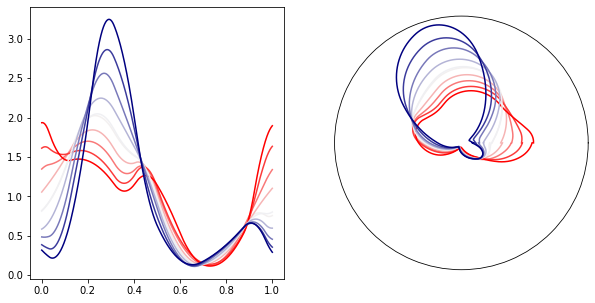

In [254]:
import seaborn as sns

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

ind = 1

ext_grid = np.linspace(0, 1, 10000)
theta_grid = 2 * np.pi * ext_grid

pos_lambdas = np.linspace(0.0001, 0.05, 5)
neg_lambdas = np.linspace(-0.001, -0.05, 5)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))

for i, lam in enumerate(pos_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    pdf = get_smooth_pdf(m, ext_grid)
    
    ax1.plot(ext_grid,  pdf, color=pos_palette[i], alpha=1.0)
    ax2.plot(theta_grid, pdf, color=pos_palette[i], alpha=1.0)
    
    
for i, lam in enumerate(neg_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    pdf = get_smooth_pdf(m, ext_grid)
    
    ax1.plot(ext_grid,  pdf, color=neg_palette[i], alpha=1.0)
    ax2.plot(theta_grid, pdf, color=neg_palette[i], alpha=1.0)
    

#ax1.plot(ext_grid, bary_measure.periodic_cdf(0, ext_grid), color="red", lw=3)
#ax2.plot(theta_grid, bary_measure.eval_smooth_pdf(ext_grid), color="red", lw=3)
#ax1.set_xlim(0, 1)
#ax1.set_ylim(0, 1)


ax2.set_xticks([])
ax2.set_yticks([])
    
#plt.plot(ext_grid, bary_measure.periodic_cdf(0, ext_grid), color="red", lw=2)
# plt.savefig("/Users/marioberaha/Dropbox/Wass_S1/JASA/IMG/eyes_1pd.pdf", bbox_inches="tight")
#plt.savefig("uniform_pc{0}_s1w.pdf".format(ind), bbox_inches="tight")
plt.show()

In [68]:
from scipy.stats import norm

currdata = np.random.normal(size=(100))
means = np.random.normal(size=(5))

In [87]:
i = -1
j = 0

a = norm.logpdf(currdata[:, np.newaxis], means, scale=1)
b = np.arange(5) / 5
c = a + b

c[i, j] == a[i, j] + b[j]

True

In [90]:
from scipy.special import logsumexp

logsumexp(c, axis=1).shape

(100,)